In [1]:
%load_ext autoreload
%autoreload 2

from src.data.datamodule import SVHNDataModule
from src.data.dataset import StaticImageDataset
import torch
import numpy as np
from torchvision.datasets import SVHN, CIFAR10, MNIST

In [2]:
ds = MNIST(
    root='/home/shate/Desktop/projects/image-classification/data/MNIST', train=True, download=False
)

In [7]:
np.where(shape == n_channels)

(array([], dtype=int64),)

In [3]:
shape = np.array(ds.data.shape)
n_channels = 3 if 3 in shape else 1  # RGB or GREY
shape_idx = np.where(shape == n_channels)[0][0]

IndexError: index 0 is out of bounds for axis 0 with size 0

In [63]:
ds_ = StaticImageDataset.from_external(ds)

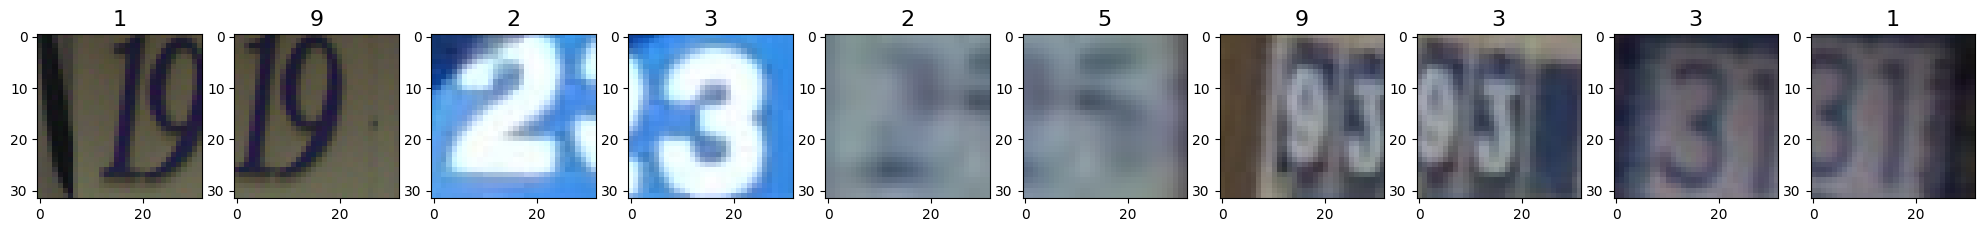

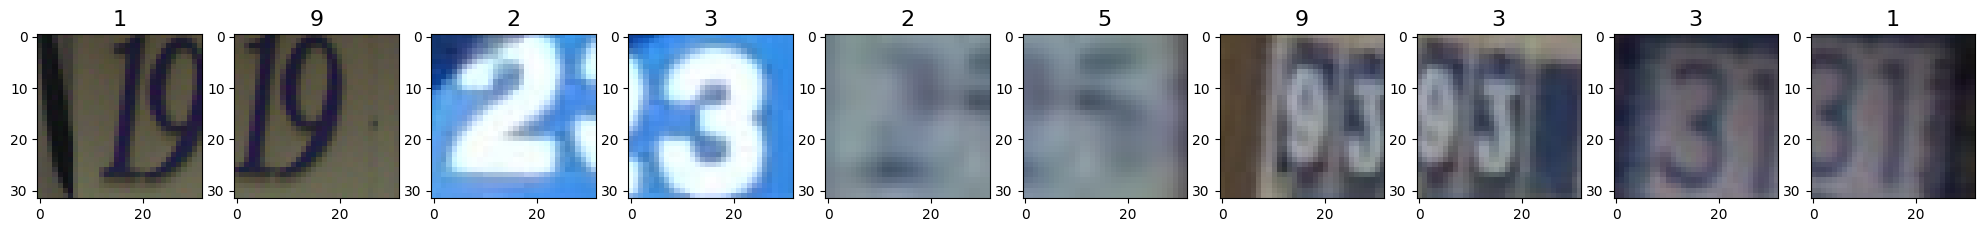

In [64]:
ds_.plot_images()

In [65]:
dm = SVHNDataModule()


In [66]:
dm.download_data()

Using downloaded and verified file: /home/shate/Desktop/projects/image-classification/data/SVHN/train_32x32.mat
Using downloaded and verified file: /home/shate/Desktop/projects/image-classification/data/SVHN/test_32x32.mat


In [67]:
dm.setup()

In [68]:
dm.classes

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']